<a href="https://colab.research.google.com/github/mtcarilli/bursty-deg-cme/blob/main/deg_cme_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np

import scipy
from scipy.integrate import odeint
from scipy.fft import ifft, ifft2, ifftn, irfft, irfftn

import matplotlib.pyplot as plt

In [33]:
# get grid of u to solve PGF on before IFFT -- from Gennady, https://github.com/mtcarilli/ATAC_RNA/blob/main/pss_evaluation.py#L40
def get_g(mx):
    u = []
    for i in range(len(mx)):
        l = np.arange(mx[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    g = [g_.flatten() for g_ in g]
    return g

In [92]:
# define the ODEs

def coupled_PGF(G,s,u,k,lambda1,lambda2,r1,r2):
  '''Sets up the coupled PGFs dG1/ds and dG2/ds for a model of constitutive transcription with two states of degradation.

  Variables
  -------------
  G: list of [G1,G2]
  s: integral variable
  u: PGF variable, change of variables u = g -1
  k: rate of transcription
  lambda1: rate of degradation of G1
  lambda2: rate of degradation of G2
  r1: rate of switching between state 2 and 1
  r2: rate of switching between state 1 and 2
  '''
  G1,G2 = G
  dG1ds = k*u*np.exp(-lambda1*s)*G1 + r1*G2 -  r2*G1
  dG2ds = k*u*np.exp(-lambda2*s)*G2 + r2*G1 -  r1*G2
  return [dG1ds,dG2ds]



k = 1
lambda1 = 1
lambda2 = 1
r1 = 1     # mostly in the active degradation state
r2 = 1    # switching is slower than transcription?


H = np.array([[-r2,r2],[r1,-r1]])   # state switching matrix
Hfin = scipy.linalg.null_space(H.T)  # set initial condition using null space of transition matrix
Hfin /= Hfin.sum()
initcond = Hfin.squeeze()
initcond = [1,1]





In [93]:

t = np.linspace(0, 10, 10000)
lim = 1000
mx = [int(lim)]
g = get_g(mx)

pgf = np.zeros((lim,2))

for i,u in enumerate(g[0]):
  pgf[i,:]  = odeint(coupled_PGF, initcond, t, args=(u, k, lambda1, lambda2, r1, r2))[-1,:]

PSS = np.zeros(mx + [2])

PSS[:,0] = np.real( ifft2(np.reshape(pgf[:,0], (-1,100) ) ).flatten() )
PSS[:,1] = np.real( ifft2(np.reshape(pgf[:,1], (-1,100) ) ).flatten() )

/usr/local/lib/python3.11/dist-packages/scipy/integrate/_odepack_py.py:247: ComplexWarning: Casting complex values to real discards the imaginary part
  output = _odepack.odeint(func, y0, t, args, Dfun, col_deriv, ml, mu,


In [94]:
PSS = np.abs(PSS)
PSS = PSS/PSS.sum()

In [95]:
PSS.sum()

np.float64(1.0)

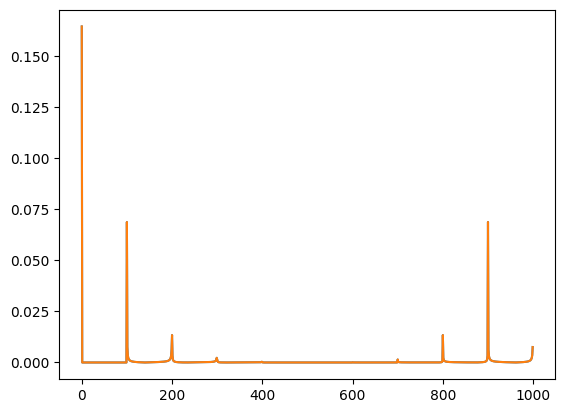

In [96]:
plt.plot(PSS[:,0])
plt.plot(PSS[:,1])